In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import torch

os.environ['pRT_input_data_path'] = os.path.join('/home/mvasist/pRT/input_data')

from itertools import islice
from pathlib import Path
from tqdm import tqdm

from lampe.data import H5Dataset
from lampe.inference import NPE
from lampe.nn import ResMLP
from lampe.nn.flows import NAF
from lampe.plots import nice_rc, corner, rank_ecdf

from ees import Simulator, LABELS, LOWER, UPPER, pt_profile

##########################################################################################
from lampe.plots import LinearAlphaColormap
import matplotlib as mpl
import pandas as pd
import csv
from lampe.distributions import BoxUniform
import time
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from numpy import genfromtxt



In [2]:
def sampling_from_post(x, name, only_returning = True):
    
    if not only_returning: 
        with torch.no_grad():
            x = embedding(x.cuda())
            theta = torch.cat([
                estimator.sample(x, (2**14,)).cpu()
                for _ in tqdm(range(2**6))
            ])

        ##Saving to file

        theta_numpy = theta.double().numpy() #convert to Numpy array
        df_theta = pd.DataFrame(theta_numpy) #convert to a dataframe
        df_theta.to_csv( name ,index=False) #save to file
    

    #Then, to reload:
    df_theta = pd.read_csv(name)
    theta = df_theta.values
    return theta
    
        
def legends(axes = None, creds=  [.6827, .9545, .9973], alpha = (0., .5), color = 'steelblue', labl = False):
    
    if ((np.shape(axes) == (10, 10)) | (np.shape(axes) == (3,3))):
        handles, texts = axes[0, -1].get_legend_handles_labels()
    else:
        handles, texts = axes.get_legend_handles_labels()

    # Quantiles
    creds = np.sort(np.asarray(creds))[::-1]
    creds = np.append(creds, 0)

    cmap = LinearAlphaColormap(color, levels=creds, alpha=alpha)

    levels = (creds - creds.min()) / (creds.max() - creds.min())
    levels = (levels[:-1] + levels[1:]) / 2
    
    cl = 1
    for c, l in zip(creds[:-1], levels):
        handles.append(mpl.patches.Patch(color=cmap(l), linewidth=0))
        if labl == False: 
            texts.append(r'${:.1f}\,\%$ credible region'.format(c * 100))
        else: 
            texts.append(str(4-cl)+' $\sigma$')
            cl+=1
        
    return handles, texts

bounds_lower = [0.4, -1, -8, -2.7, -2.7, -2, 4, 0.7, 2.8,0.8] 
bounds_upper = [0.7, 1, 4, 1.5, 1.5, 11, 14, 3.5, 4.5, 1.4]

def corner_mod(theta1, theta2, marker1, marker2, legend, color, creds, alpha):
    ##Looping
    bounds_lower = [0.4, -1, -8, -2.7, -2.7, -2, 4, 0.7, 2.8,0.8] 
    bounds_upper = [0.7, 1, 4, 1.5, 1.5, 11, 14, 3.5, 4.5, 1.4]

    fig1 = corner(
        theta1,
        smooth=2,
    #     bounds=(lower[:10], upper[:10]),
        bounds = (bounds_lower, bounds_upper),
    #         bounds = (LOWER[:10], UPPER[:10]),
        labels=LABELS[:10],
    #         legend='nested sampling',
        markers= marker1,
        figsize=(10, 10),
        creds = creds,
        alpha = alpha, 
        color= color[0], 
    )

    fig = corner(
        theta2,
        smooth=2,
        bounds = (bounds_lower, bounds_upper),
        labels=LABELS[:10],
    #         legend=r'NPE $q_{\phi}(\theta | x^*)$',
        markers= marker2,
        creds = creds,
        color= color[1],
        alpha = alpha, 
        figure= fig1, 
    )

    for index,ax in enumerate(fig.get_axes()):   
        ax.tick_params(axis='both', labelsize=12)
        if index<10:
            if index==0:
                ax.set_xlabel('', fontsize=12)
                ax.set_ylabel('', fontsize=12)
            else:
                ax.set_xlabel(LABELS[index], fontsize=12)
                ax.set_ylabel(LABELS[index], fontsize=12)
        else:continue
    
    figure, axes = plt.subplots( 10, 10, squeeze=False, sharex='col', gridspec_kw={'wspace': 0., 'hspace': 0.})
    legend= legend
    for i in range(len(legend)):
        lines = axes[0, -1].plot([], [], color=color[i], label=legend[i])
    dot = axes[0, -1].plot([], [], color='black', label= r"$\theta_\textnormal{obs}$", linestyle= 'dashed')
    handles, texts = legends(axes, alpha = (0., .9))

    fig.legends.clear()
    fig.legend(handles, texts, loc='center', bbox_to_anchor=(0.4,0.915), frameon=False,  prop={'size': 12})
    
    return fig

def levels_and_creds(creds, alpha):
    creds = np.sort(np.asarray(creds))[::-1]
    creds = np.append(creds, 0)
    levels = (creds - creds.min()) / (creds.max() - creds.min())
    levels = (levels[:-1] + levels[1:]) / 2
    
    return levels, creds

def PT_plot(theta, theta_nom, color = 'steelblue', creds= [0.997, 0.955, 0.683], alpha = [0, 0.9]):
    
    levels, creds = levels_and_creds(creds, alpha)
    cmap= LinearAlphaColormap('steelblue', levels=creds, alpha=alpha)
    
    pressures = simulator.atmosphere.press / 1e6
    temperatures = pt_profile(theta , pressures)

    fig, ax = plt.subplots(figsize=(4,4))

    for q, l in zip(creds[:-1], levels):
        left, right = np.quantile(temperatures, [0.5 - q / 2, 0.5 + q / 2], axis=0)
        ax.fill_betweenx(pressures, left, right, color= cmap(l), linewidth=0)

    lines = ax.plot([], [], color='black', label='Nominal P-T profile')
    handles, texts = legends(ax, alpha=alpha) #[0.15,0.75]

    ax.plot(pt_profile(theta_nom, pressures), pressures, color='black', label= 'Synthetic observation')
    ax.set_xticklabels(np.arange(500,4000,500),fontsize=8)
    ax.set_yticklabels(np.arange(1e-2, 1e1, np.log10(0.1)),fontsize=8)
    ax.set_xlabel(r'Temperature $(\mathrm{K})$', fontsize= 10)
    ax.set_ylabel(r'Pressure $(\mathrm{bar})$', fontsize= 10)
    ax.set_xlim(300, 3000)
    ax.set_ylim(1e-2, 1e1)
    ax.set_yscale('log')
    ax.legend(handles, texts, prop={'size': 8})
    ax.invert_yaxis()
#     ax.grid()
    
    return fig 
    
def adding_lines(value, fig, c):
    # Extract the axes
    axes = np.array(fig.axes).reshape((10, 10))
    # Loop over the diagonal
    for i in range(10):
        ax = axes[i, i]
        ax.axvline(value[i], color=c, linewidth= 0.4)
    # Loop over the histograms
    for yi in range(10):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(value[xi], color=c, linewidth= 0.4)
            ax.axhline(value[yi], color= c, linewidth= 0.4)
            ax.plot(value[xi], value[yi], color = c, marker='o', markersize=2)
            
def sim_spectra(theta, theta_name, x_name, only_returning = True):
    
    if not only_returning:
        x = np.stack([simulator(t) for t in tqdm(theta)])
        mask = ~np.isnan(x).any(axis=-1)
        theta, x = theta[mask], x[mask]

        ## to save
        df_theta = pd.DataFrame(theta) #convert to a dataframe
        df_x = pd.DataFrame(x) #convert to a dataframe

        df_theta.to_csv(theta_name,index=False) #save to file
        df_x.to_csv(x_name,index=False) #save to file
    

    #Then, to reload:
    df_theta = pd.read_csv(theta_name)
    theta = df_theta.values
    df_x = pd.read_csv(x_name)
    x = df_x.values

    return theta, x
            

In [3]:
plt.rcParams.update(nice_rc(latex=True))

In [4]:
# scratch = os.environ.get('SCRATCH', '')
scratch = '/scratch/users/frozet/'
datapath = Path(scratch) / 'ees/data_379'

#Old
# runpath = Path(scratch) / 'eac/runs/atomic-sun-1'

#Noisy
runpath = Path(scratch) / 'eac/runs/fresh-dew-1' ###
savepath = Path('/home/mvasist/scripts_lampe/plots_paper/fresh-dew-1/') ###
savepath1 = Path('/home/mvasist/scripts_lampe/plots_paper/fresh-dew-1/gridless/')

## Simulator

In [5]:
simulator = Simulator(noisy=False)

def noisy(x):
    return x + simulator.sigma * torch.randn_like(x)

## Estimator

In [6]:
embedding = ResMLP(379, 64, hidden_features=[512] * 2 + [256] * 3 + [128] * 5, activation='ELU')
estimator = NPE(
    16, 64,
    moments=(torch.zeros(16), torch.ones(16)),
    transforms=3,
    build=NAF,
    signal=16,
    hidden_features=[512] * 5,
    activation='ELU',
)

states = torch.load(runpath / 'states.pth', map_location='cpu')

embedding.load_state_dict(states['embedding'])
estimator.load_state_dict(states['estimator'])

embedding.cuda().eval()
estimator.cuda().eval()

NPE(
  (flow): NAF(
    (transforms): ModuleList(
      (0): AffineTransform()
      (1): NeuralAutoregressiveTransform(
        (base): MonotonicTransform()
        (order): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
        (params): MaskedMLP(
          (0): MaskedLinear(in_features=80, out_features=512, bias=True)
          (1): ELU(alpha=1.0)
          (2): MaskedLinear(in_features=512, out_features=512, bias=True)
          (3): ELU(alpha=1.0)
          (4): MaskedLinear(in_features=512, out_features=512, bias=True)
          (5): ELU(alpha=1.0)
          (6): MaskedLinear(in_features=512, out_features=512, bias=True)
          (7): ELU(alpha=1.0)
          (8): MaskedLinear(in_features=512, out_features=512, bias=True)
          (9): ELU(alpha=1.0)
          (10): MaskedLinear(in_features=512, out_features=256, bias=True)
        )
        (transform): MonotonicMLP(
          (0): MonotonicLinear(in_features=17, out_features=64, bias=True)
          (1): TwoWayELU(al

## Coverage

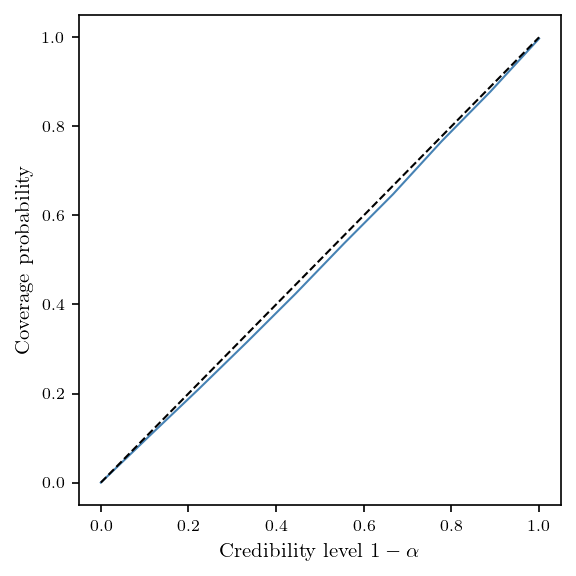

In [7]:
# testset = H5Dataset(datapath / 'test.h5', batch_size=16)

# ranks = []

# with torch.no_grad():
#     for theta, x in tqdm(islice(testset, 128)):
#         theta, x = theta.cuda(), x.cuda()
#         x = noisy(x)
#         x = embedding(x)

#         posterior = estimator.flow(x)
#         samples = posterior.sample((1024,))

#         log_p = posterior.log_prob(theta)
#         log_p_samples = posterior.log_prob(samples)

#         ranks.append((log_p_samples < log_p).float().mean(dim=0).cpu())
        
# ranks = torch.cat(ranks)   
# ranks_numpy = ranks.double().numpy() #convert to Numpy array
# df_ranks = pd.DataFrame(ranks_numpy) #convert to a dataframe
# df_ranks.to_csv(savepath /"ranks.csv",index=False) #save to file

df_ranks = pd.read_csv(savepath/"ranks.csv")
ranks = df_ranks.values

### ECDF
# fig = rank_ecdf(ranks)
# fig.savefig(savepath / 'ecdf.pdf')

### Coverage
a=[]
r = np.sort(np.asarray(ranks))

for alpha in np.linspace(0,1,10):
    a.append((r > (1-alpha)).mean())

plt.figure(figsize=(4, 4))
plt.xlabel(r'Credibility level $1-\alpha$', fontsize = 10)
plt.ylabel(r'Coverage probability', fontsize= 10)
plt.plot(np.linspace(0,1,10),a, color='steelblue', label='upper right') #a[::-1]
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
# plt.grid()
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# plt.savefig(savepath1 / 'coverage.pdf')
plt.show()


## Corner

In [7]:
eventset = H5Dataset(datapath / 'event.h5')
theta_star, x_star = eventset[1] #noisy_instance_old
theta0_star, x0_star = eventset[0] #noiseless
theta2_star, x2_star = eventset[2] #noisy_instance_new

In [10]:
# syn_obs_noiseinst_old = pd.read_csv('/home/mvasist/scripts_lampe/paul/syn_obs_noiseinst_old.csv', header=None)
# wlength = syn_obs_noiseinst_old.iloc[:,0]

In [11]:
# wlength = np.linspace(0.95, 2.45, x_star.shape[-1])

In [12]:
# fig, ax = plt.subplots()
# ax.plot(wlength, x_star, color='black', label = r'$x_\textnormal{obs}$', linewidth= 1.5) #x*+$\epsilon$

# ax.spines.right.set_visible(False)
# ax.spines.top.set_visible(False)

# # Only show ticks on the left and bottom spines
# ax.yaxis.set_ticks_position('left')
# ax.xaxis.set_ticks_position('bottom')

# plt.xlabel('Wavelength ($\mu$)', fontsize = 20)
# plt.ylabel(r'Planet flux $F_\nu$' '\n' r'(10$^{-16}$ W m$^{-2}$ $\mu$m$^{-1}$)', fontsize= 20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize =20)
# plt.savefig(savepath / 'noisy.pdf')

# plt.show()

In [8]:
theta = sampling_from_post(x_star, savepath/'theta.csv', only_returning = True)
theta0 = sampling_from_post(x0_star, savepath/'theta0.csv', only_returning = True)
theta2 = sampling_from_post(x2_star, savepath/'theta2.csv', only_returning = False)

100%|██████████| 64/64 [08:01<00:00,  7.52s/it]


In [16]:
theta_paul = torch.load('/home/mvasist/scripts_lampe/paul/post_noiseinstnew.pth')
# theta_paul_noiseless = torch.load('/home/mvasist/scripts_lampe/paul/post_noiseless.pth')

In [17]:
np.shape(theta_paul), np.shape(theta[:30288])

(torch.Size([30740, 16]), (30288, 16))

## Retrieving over noisy spectrum NPE vs NS

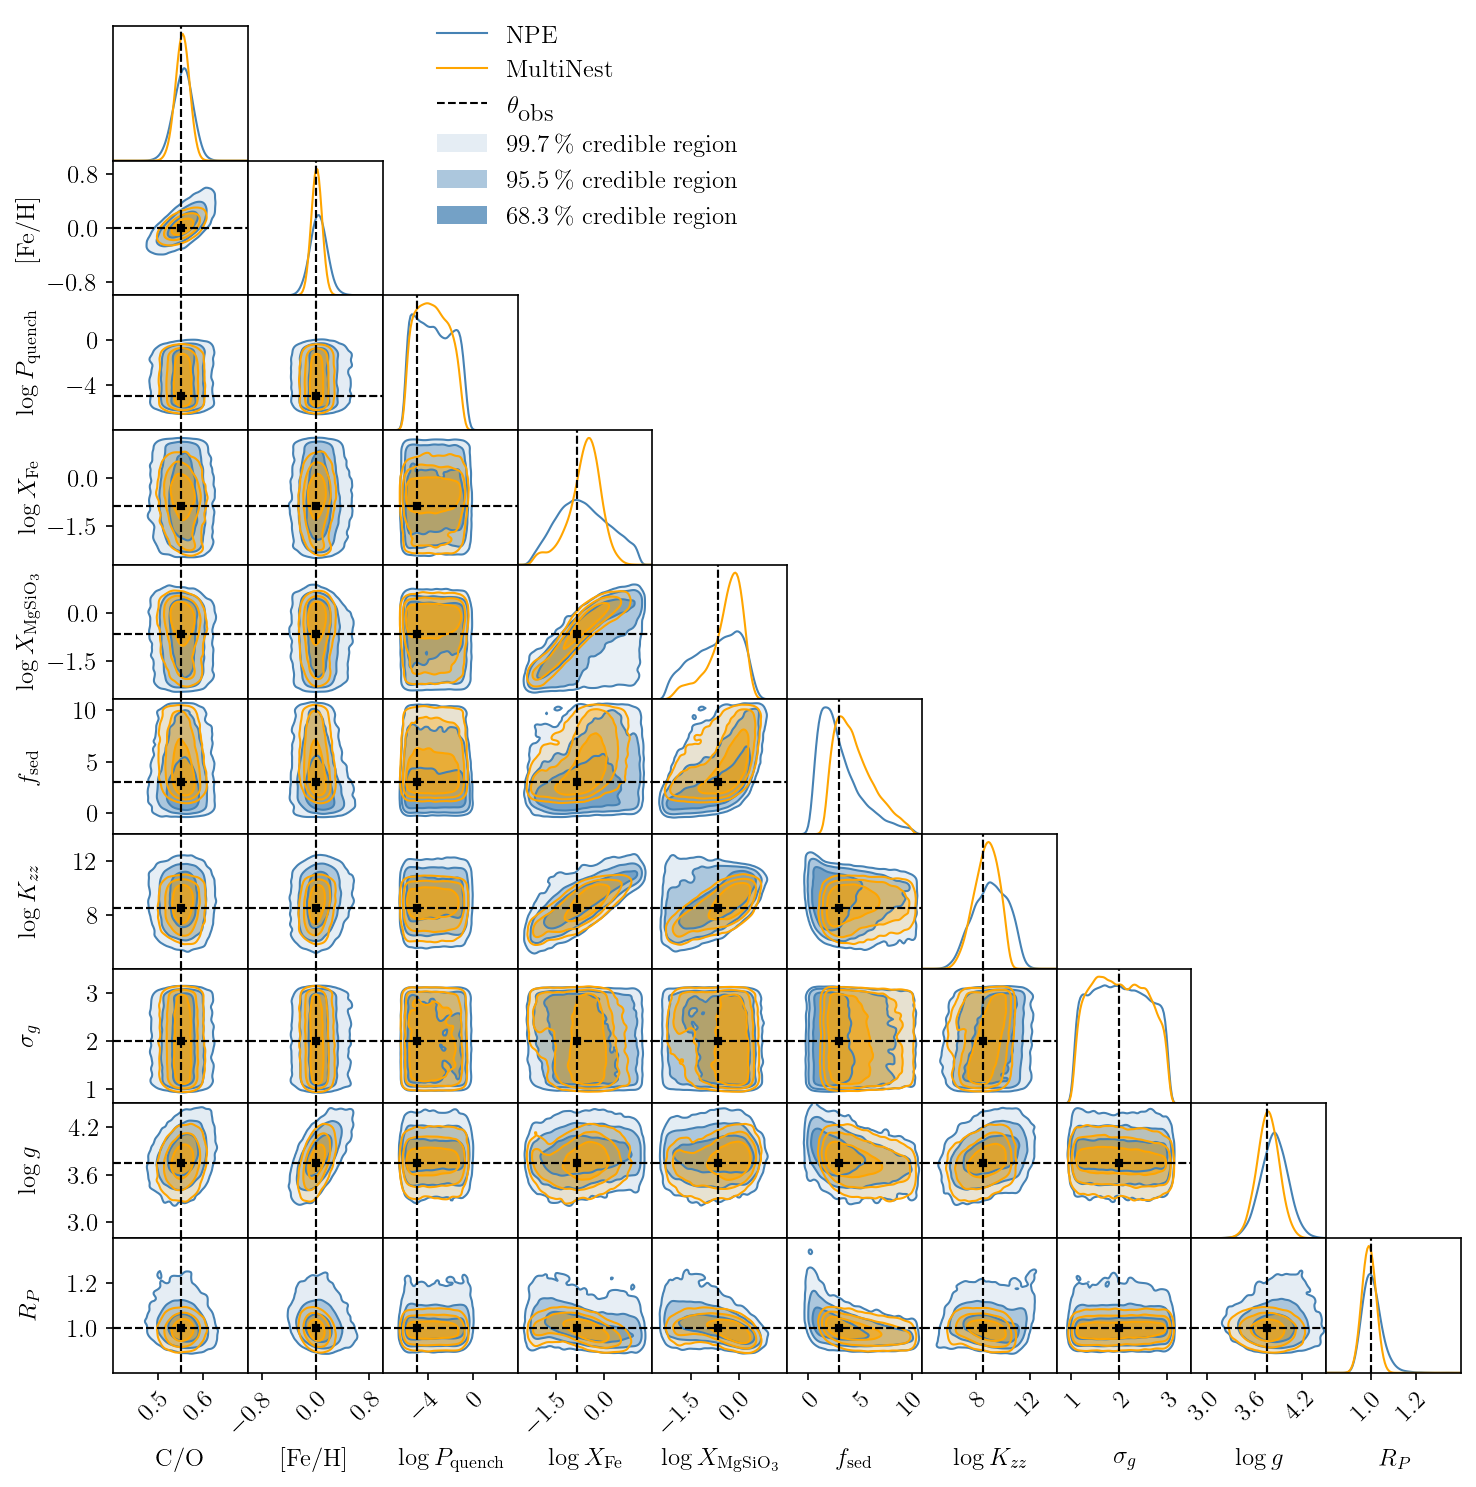

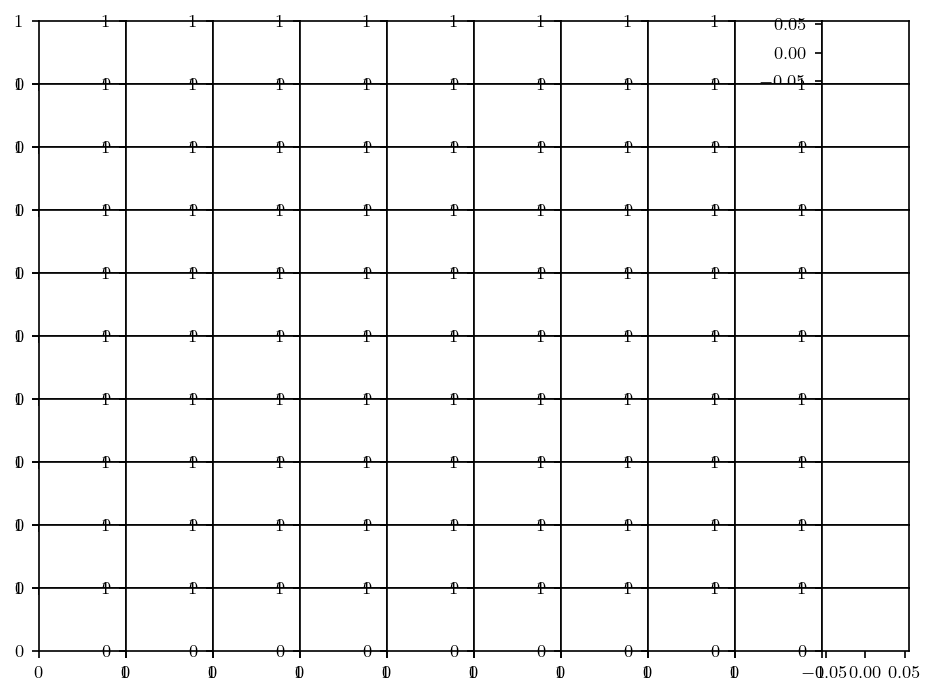

In [15]:
fig = corner_mod(theta0[:30288,:10], theta_paul[:,:10], [theta_star[:10]], [theta_star[:10]], ['NPE', 'MultiNest'], ['steelblue', 'orange'], [0.6827, 0.9545, 0.9973], (0., .9))
fig.savefig(savepath1 / 'new_corner_noiseless_v5.pdf')

## Posterior more

In [14]:
testset = H5Dataset(datapath / 'test.h5')

In [106]:
# !ls /scratch/users/frozet/ees/data_379

In [189]:
theta1, x1 = testset[505] 
theta2, x2 = testset[506]

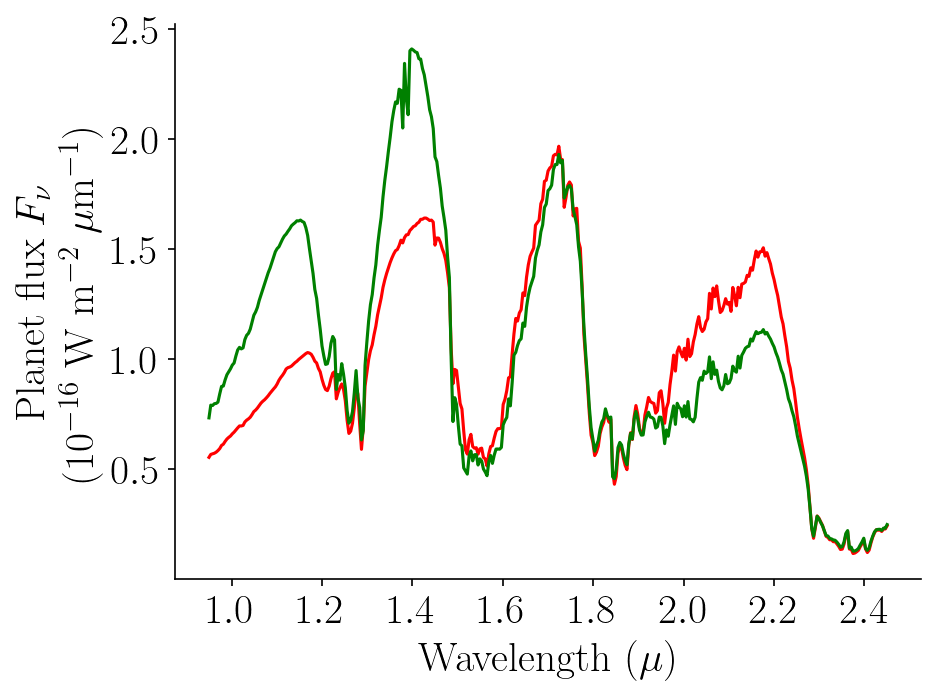

In [190]:
fig, ax = plt.subplots()
ax.plot(wlength, x1, color='red', label = r'$x_\textnormal{obs}$', linewidth= 1.5) #x*+$\epsilon$
ax.plot(wlength, x2, color='green', label = r'$x_\textnormal{obs}$', linewidth= 1.5)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Wavelength ($\mu$)', fontsize = 20)
plt.ylabel(r'Planet flux $F_\nu$' '\n' r'(10$^{-16}$ W m$^{-2}$ $\mu$m$^{-1}$)', fontsize= 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize =20)

plt.show()

In [191]:
theta1_samples = sampling_from_post(x1, savepath/'theta1.csv', only_returning = False)
theta2_samples = sampling_from_post(x2, savepath/'theta2.csv', only_returning = False)

100%|██████████| 64/64 [03:37<00:00,  3.40s/it]


In [64]:
# fig = corner_mod(theta1_samples[:33078,:10], theta2_samples[:33078,:10], [theta1[:10]], [theta2[:10]], ['NPE 1', 'NPE 2'], ['steelblue', 'orange'])
# fig.savefig(savepath / 'corner_diff_obs.pdf')

## PT-profile

In [36]:
theta_star, x_star = theta_star.double().numpy(), x_star.double().numpy()

/tmp/ipykernel_2574714/1483516777.py:136: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(500,4000,500),fontsize=8)


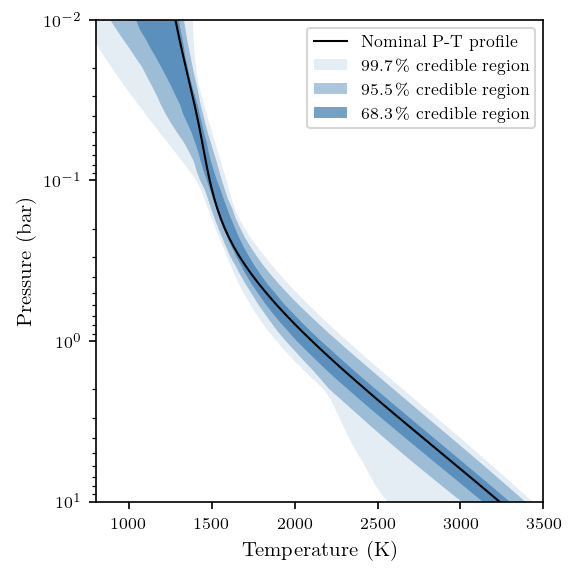

In [83]:
fig_pt = PT_plot(theta[:2**8], theta_star)
# fig_pt.savefig(savepath1 / 'pt_profile.pdf')

In [38]:
# fig_pt = PT_plot(theta_paul[:2**8], theta_star)
# fig.savefig(savepath / 'pt_profile_paul.pdf')

## Consistency

In [11]:
theta_256, x_256 = sim_spectra(theta[:2**8], savepath /"theta_256.csv", savepath /"x_256.csv", only_returning = True)

/tmp/ipykernel_556030/983534092.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.round(np.arange(0, 4.0, 0.4),1), fontsize=8)
/tmp/ipykernel_556030/983534092.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(np.round(np.arange(0.8, 2.6, 0.2),1),fontsize=8)


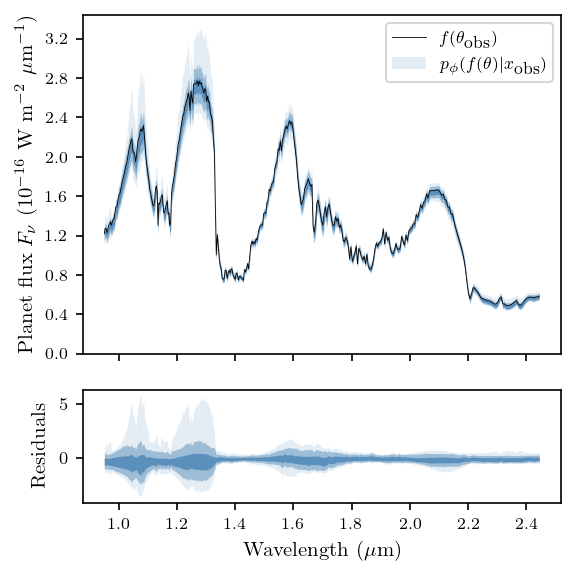

In [12]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(4,4), gridspec_kw={'height_ratios': [3, 1]})
# cc = ['lightsteelblue', 'dodgerblue', 'midnightblue']

creds= [0.997, 0.955, 0.683]
alpha = (0.0, 0.9)
levels, creds = levels_and_creds(creds= creds, alpha = alpha)
cmap= LinearAlphaColormap('steelblue', levels=creds, alpha=alpha)

for q, l in zip(creds[:-1], levels):
#     cls = tuple(mcolors.to_rgba(mcolors.CSS4_COLORS[cc[i]])[:3])
    lower, upper = np.quantile(x_256, [0.5 - q / 2, 0.5 + q / 2], axis=0)
    ax1.fill_between(wlength, lower, upper, color= cmap(l), linewidth=0) #'C0', alpha=0.4,

lines = ax1.plot(wlength, x0_star, color='black', label = r'$ f(\theta_{obs})$', linewidth = 0.4)

handles, texts = legends(axes= ax1, alpha=alpha) #0.15, 0.75

texts = [r'$ f(\theta_\textnormal{obs})$', r'$p_{\phi}(f(\theta)|x_\textnormal{obs})$']

plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_yticklabels(np.round(np.arange(0, 4.0, 0.4),1), fontsize=8)
ax1.set_ylabel(r'Planet flux $F_\nu$ (10$^{-16}$ W m$^{-2}$ $\mu$m$^{-1}$)', fontsize = 10)
ax1.set_ylim(-0.5,3.8)
ax1.legend(handles, texts, prop = {'size': 8}, bbox_to_anchor=(1,1))
# ax1.grid()

residuals = (torch.from_numpy(x_256) - x0_star) / simulator.sigma

for q, l in zip(creds[:-1], levels):
    #     cls = tuple(mcolors.to_rgba(mcolors.CSS4_COLORS[cc[i]])[:3])
    lower, upper = np.quantile(residuals, [0.5 - q / 2, 0.5 + q / 2], axis=0)
    ax2.fill_between(wlength, lower, upper, color= cmap(l) , linewidth=0) #'C0', alpha=0.4
# ax2.set_ylabel(r'$p(\epsilon | x_{obs})$', fontsize = 10)
ax2.set_ylabel(r'Residuals $ $', fontsize = 10)
ax2.set_xlabel( r'Wavelength ($\mu$m)', fontsize = 10)
ax2.set_xticklabels(np.round(np.arange(0.8, 2.6, 0.2),1),fontsize=8) 
# ax2.grid()
fig.savefig(savepath1 / 'consistency_wlfixed.pdf')
plt.show()


## Cloudless

In [13]:
df_theta_256 = pd.DataFrame(theta_256)

# Light clouds

df_theta_light = df_theta_256
df_theta_light['5'] = 10
df_theta_light['6'] = 13
df_theta_light['7'] = 3
theta_light = df_theta_light.values

theta_light, x_light = sim_spectra(theta_light, savepath /"theta_light.csv", savepath /"x_light.csv", only_returning = True)

## Cloudless

df_theta_cloudless = df_theta_256
df_theta_cloudless['3'] = -10
df_theta_cloudless['4'] = -10
theta_cloudless = df_theta_cloudless.values

theta_cloudless, x_cloudless = sim_spectra(theta_cloudless, savepath /"theta_cloudless.csv", savepath /"x_cloudless.csv", only_returning = True)

/tmp/ipykernel_556030/1511508423.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(np.arange(0.8, 2.6, 0.2),1),fontsize=8)


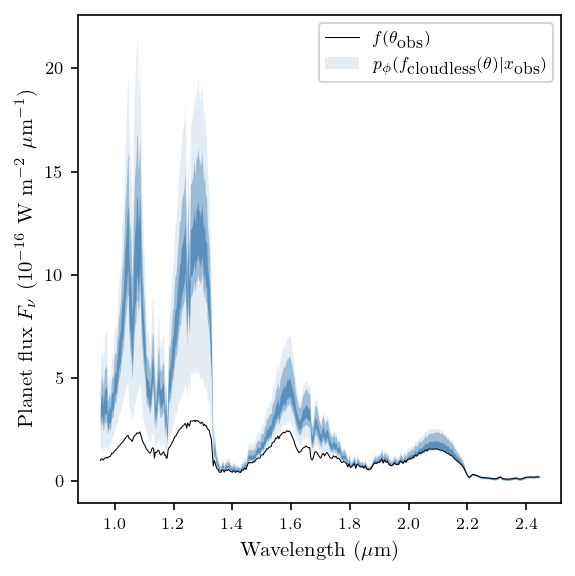

In [14]:
fig, ax = plt.subplots(figsize=(4, 4))

for q, l in zip(creds[:-1], levels):
#     cls = tuple(mcolors.to_rgba(mcolors.CSS4_COLORS[cc[i]])[:3])
    lower, upper = np.quantile(x_cloudless, [0.5 - q / 2, 0.5 + q / 2], axis=0)
    ax.fill_between(wlength, lower, upper, color= cmap(l), linewidth=0)

lines = ax.plot(wlength, x0_star, color='black', label = r'$ f(\theta_\textnormal{obs})$', linewidth = 0.5)
# lines1= ax.plot([],[], color='white', label = r'$p(f(\theta)|x_{obs})$')

handles, texts = legends(axes= ax, alpha=alpha) #[0.15,0.75]

texts = [r'$ f(\theta_\textnormal{obs})$', r'$p_{\phi}(f_\textnormal{cloudless}(\theta)|x_\textnormal{obs})$']

# ax.set_title('')
ax.set_xticklabels(np.round(np.arange(0.8, 2.6, 0.2),1),fontsize=8) 
ax.set_xlabel( r'Wavelength ($\mu$m)', fontsize = 10)
ax.set_ylabel(r'Planet flux $F_\nu$ (10$^{-16}$ W m$^{-2}$ $\mu$m$^{-1}$)', fontsize = 10)
# ax.set_ylim(-0.5,3.8)
ax.legend(handles, texts, prop = {'size': 8}, bbox_to_anchor=(1,1))
# ax.grid()

fig.savefig(savepath1 / 'consistency_cloudless_wlfixed.pdf')
plt.show()



# OLD PLOTS

# Outside posterior corner plot

In [ ]:
## Plotting all spectra at once 
# def plot_all_samples(c, sp):
#     plt.figure(figsize=(15, 10))
#     for j, i in enumerate(sp):
#         plt.fill_between(wlength, x_star-simulator.sigma, x_star+simulator.sigma, color = 'grey', alpha = 0.8)
#         plt.fill_between(wlength, x_star-2*simulator.sigma, x_star+2*simulator.sigma, color = 'grey', alpha = 0.2)
#         plt.fill_between(wlength, x_star-3*simulator.sigma, x_star+3*simulator.sigma, color = 'grey', alpha = 0.2)
#         spi = simulator(sp.values[j]) 
#         plt.plot(wlength, spi, color=c[j], linewidth= 0.6, label = '') #color=c[j]
#         plt.show()

# def residuals(ind, c):
#     fig, (ax1, ax2) = plt.subplots(2, figsize=(4,4), gridspec_kw={'height_ratios': [3, 1]})
   
#     ax1.plot([],[], color = 'white', alpha = 0.1, label = r"p(x$|\theta_\textnormal{obs}$)")
#     ax1.fill_between(wlength, x_star-simulator.sigma, x_star+simulator.sigma, color = 'grey', alpha = 0.8)
#     ax1.fill_between(wlength, x_star-2*simulator.sigma, x_star+2*simulator.sigma, color = 'grey', alpha = 0.2)
#     ax1.fill_between(wlength, x_star-3*simulator.sigma, x_star+3*simulator.sigma, color = 'grey', alpha = 0.2)
#     ax1.grid()
    
#     for j, i in enumerate(ind): 
#         simulated = simulator(i)
#         if j==0:
#             spec = [simulated]  
#         else:
#             spec = np.append(spec,[simulated], axis=0)
#         ax1.plot(wlength, simulated, color=c[j], linewidth= 0.6, label = '') 
#         handles, texts = legends(axes = ax1, color = 'grey', alpha=[0.05,0.8], labl = True)  
#         ax1.set_xticklabels(np.round(np.arange(0.8, 2.6, 0.2),1), fontsize=8)
#         ax1.set_yticklabels(np.round(np.arange(0, 4.0, 0.4),1), fontsize=8)
#         ax1.set_ylabel(r'Planet flux $F_\nu$ (10$^{-16}$ W m$^{-2}$ $\mu$m$^{-1}$)', fontsize = 10)
#         ax1.legend(handles, texts, prop={'size':8})#, bbox_to_anchor=(0.55,0.98))  #(0.51,0.76)

#     residuals = (torch.from_numpy(spec) - x_star) / simulator.sigma

#     for j, r in enumerate(residuals):
#         ax2.plot(wlength, r ,color=c[j], alpha=1)
#     ax2.set_ylabel(r'Residuals $ $', fontsize = 10)
#     ax2.set_xlabel( r'Wavelength ($\mu$m)', fontsize = 10)
#     ax2.set_xticklabels(np.round(np.arange(0.8, 2.6, 0.2),1),fontsize=8) 
#     ax2.set_ylim([-4,4])
#     ax2.grid()
#     return fig
    

### Outside MN but inside NPE

In [ ]:
# sp = pd.DataFrame(theta)
# indx = sp[(sp[0] < 0.6 ) | (sp[1] < 0.3) | (sp[5] > 1.5) |(sp[6] < 11.5)| (sp[8] < 3.7) |(sp[9] < 1.05)].index #    #everything lesser than 0
# sp = sp.drop(indx)
# sp.to_csv(savepath/ 'sp.csv')

# print(len(sp))

# sp = pd.read_csv(savepath/ 'sp.csv')
# sp = sp[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']]
# sp

# plot_all_samples(c, sp[30:])

# sp = pd.DataFrame(theta)
# indxa = sp.values[8] 
# indxb = sp.values[18]
## indxc = sp.values[37]

# ind = [indxa, indxb]
# fig = residuals(ind, ['red', 'blue'])
# fig.savefig(savepath / 'residuals_outside_posterior_spectra.pdf')

### Outside NPE but inside MN

In [ ]:
# sp_mn = pd.DataFrame(theta_paul.numpy())
# indx_mn = sp_mn[(sp_mn[8] > 3)].index# |(sp[0] > 0.5)].index #    #everything lesser than 0
# #(sp[0] > 0.55) | (sp[1] > -0.1)| (sp[2] < -1.5)|(sp[3]< 0) | (sp[4] < 0) |(sp[5] < 5)| (sp[6] < 10) |
# sp_mn = sp_mn.drop(indx_mn)
# sp_mn.to_csv(savepath/ 'sp_MN.csv')

# sp_mn = pd.read_csv(savepath/ 'sp_MN.csv')
# sp_mn = sp_mn[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']]
# sp_mn

# indxamn = sp_mn.values[8] 
# indxbmn = sp_mn.values[18]
# # indxcmn = sp_mn.values[37]

# indmn = [indxamn, indxbmn]
# fig = residuals(indmn, ['brown', 'darkgreen'])
# fig.savefig(savepath / 'residuals_MN.pdf')
   

In [ ]:
# c = ['red', 'blue', 'brown', 'darkgreen']
# fig = corner_mod(['NPE', 'MultiNest'])

# ind_all = [indxa, indxb, indxamn, indxbmn]
# for j, i  in enumerate(ind_all):
#     adding_lines(i, fig, c[j])
    
# fig.savefig(savepath / 'outside_posterior_samples.pdf')
# plt.show()

## corner of cloud samples in the PPD

In [ ]:
# fig1 = corner(
#     theta_256[:, 5:8],
#     smooth=2,
#     bounds = (bounds_lower[5:8], bounds_upper[5:8]),
#     labels=LABELS[5:8],
# #     legend='Nested noisy',
#     markers=[theta_star[5:8]],
#     figsize=(3,3),
#     color='steelblue'
# )

# fig =  corner(
#         theta_paul[:,5:8],
#         smooth=2,
#         bounds=(bounds_lower[5:8], bounds_upper[5:8]), #LOWER,UPPER
#         labels=LABELS[5:8],
# #         legend=r'NPE $q_{\phi}(\theta | x^*)$',
#         markers=[theta_star[5:8]],
#         color= 'orange',
#         figure= fig1
# )

# figure, axes = plt.subplots( 3, 3, squeeze=False, sharex='col', gridspec_kw={'wspace': 0., 'hspace': 0.})
# color = ['steelblue', 'orange']
# legend= ['NPE', 'MultiNest']
# for i in range(len(legend)):
#     lines = axes[0, -1].plot([], [], color=color[i], label=legend[i])
# dot = axes[0, -1].plot([], [], color='black', label= r"$\theta_{obs}$", linestyle= 'dashed')
# handles, texts = legends(axes) 

# for indx,ax in enumerate(fig.get_axes()):
#     ax.tick_params(axis='both', labelsize=12)
#     if indx<3:
#         if indx==0:
#             ax.set_xlabel('', fontsize=12)
#             ax.set_ylabel(LABELS[indx+5], fontsize=12)
#         else:
#             ax.set_xlabel(LABELS[indx], fontsize=12)
#             ax.set_ylabel(LABELS[indx], fontsize=12)
#     else:continue
        
# fig.legends.clear()
# fig.legend(handles, texts, loc='upper right', frameon=False,  prop={'size': 6})# bbox_to_anchor=(0.4,0.915)

# fig.savefig(savepath / 'corner_noisy_clouds.pdf')


## Retrieving over noiseless spectrum NPE vs NS

In [ ]:
# fig1 = corner(
#     theta_paul_noiseless [:, :10],
#     smooth=2,
#     bounds = (bounds_lower, bounds_upper),
#     labels=LABELS[:10],
# #     legend='Nested noiseless',
#     markers=[theta_star[:10]],
#     figsize=(10,10),
#     color='steelblue'

# )

# fig =  corner(
#         theta0[:,:10],
#         smooth=2,
#         bounds=(bounds_lower, bounds_upper), #LOWER,UPPER
#         labels=LABELS[:10],
# #         legend=r'NPE $q_{\phi}(\theta | x^*)$',
#         markers=[theta_star[:10]],
#         color= 'silver',
#         figure= fig1,

#     )

# handles, texts = legends(color = ['steelblue', 'silver'], legend= ['nested sampling noiseless', r'NPE $q_{\phi}(\theta | x^*)$'])
# for indx,ax in enumerate(fig.get_axes()):
#     #ax.tick_params(axis='both', which='major', labelsize=14)
#     #ax.tick_params(axis='both', which='minor', labelsize=12)    
#     ax.tick_params(axis='both', labelsize=12)
#     if indx<10:
#         if indx==0:
#             ax.set_xlabel('', fontsize=12)
#             ax.set_ylabel(LABELS[indx], fontsize=12)
#         else:
#             ax.set_xlabel(LABELS[indx], fontsize=12)
#             ax.set_ylabel(LABELS[indx], fontsize=12)
#     else:continue
# fig.legends.clear()
# fig.legend(handles, texts, loc='center', bbox_to_anchor=(0.4,0.93), frameon=False,  prop={'size': 12})
# fig.savefig(savepath / 'corner_noiseless.pdf')


## Noiseless training vs Noisy training

In [13]:
#Noiseless
runpath_noiseless = Path('/home/mvasist/scripts_lampe/sbi-eac/models/hopeful-elevator-9')


embedding_noiseless = ResMLP(379, 64, hidden_features=[512] * 2 + [256] * 3 + [128] * 5, activation='ELU')
estimator_noiseless = NPE(
    16, 64,
    moments=(torch.zeros(16), torch.ones(16)),
    transforms=3,
    build=NAF,
    signal=16,
    hidden_features=[512] * 5,
    activation='ELU',
)
states_noiseless = torch.load(runpath_noiseless / 'states.pth', map_location='cpu')

embedding_noiseless.load_state_dict(states_noiseless['embedding'])
estimator_noiseless.load_state_dict(states_noiseless['estimator'])
embedding_noiseless.cuda().eval()
estimator_noiseless.cuda().eval()


NPE(
  (flow): NAF(
    (transforms): ModuleList(
      (0): AffineTransform()
      (1): NeuralAutoregressiveTransform(
        (base): MonotonicTransform()
        (order): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
        (params): MaskedMLP(
          (0): MaskedLinear(in_features=80, out_features=512, bias=True)
          (1): ELU(alpha=1.0)
          (2): MaskedLinear(in_features=512, out_features=512, bias=True)
          (3): ELU(alpha=1.0)
          (4): MaskedLinear(in_features=512, out_features=512, bias=True)
          (5): ELU(alpha=1.0)
          (6): MaskedLinear(in_features=512, out_features=512, bias=True)
          (7): ELU(alpha=1.0)
          (8): MaskedLinear(in_features=512, out_features=512, bias=True)
          (9): ELU(alpha=1.0)
          (10): MaskedLinear(in_features=512, out_features=256, bias=True)
        )
        (transform): MonotonicMLP(
          (0): MonotonicLinear(in_features=17, out_features=64, bias=True)
          (1): TwoWayELU(al

In [14]:
with torch.no_grad():
        x0 = embedding(x0_star.cuda())
        theta0_nl = torch.cat([
            estimator_noiseless.sample(x0, (2**14,)).cpu()
            for _ in tqdm(range(2**6))
        ])

# To save
theta0_nl_numpy = theta0_nl.double().numpy() #convert to Numpy array
df_theta0_nl = pd.DataFrame(theta0_nl_numpy) #convert to a dataframe
df_theta0_nl.to_csv(savepath /"noise_by_10/theta0_nl_hopeful-elevator-9.csv",index=False) #save to file

#Then, to reload:
df_theta0_nl = pd.read_csv(savepath/"noise_by_10/theta0_nl_hopeful-elevator-9.csv")
theta0_nl = df_theta0_nl.values

100%|██████████| 64/64 [03:36<00:00,  3.38s/it]


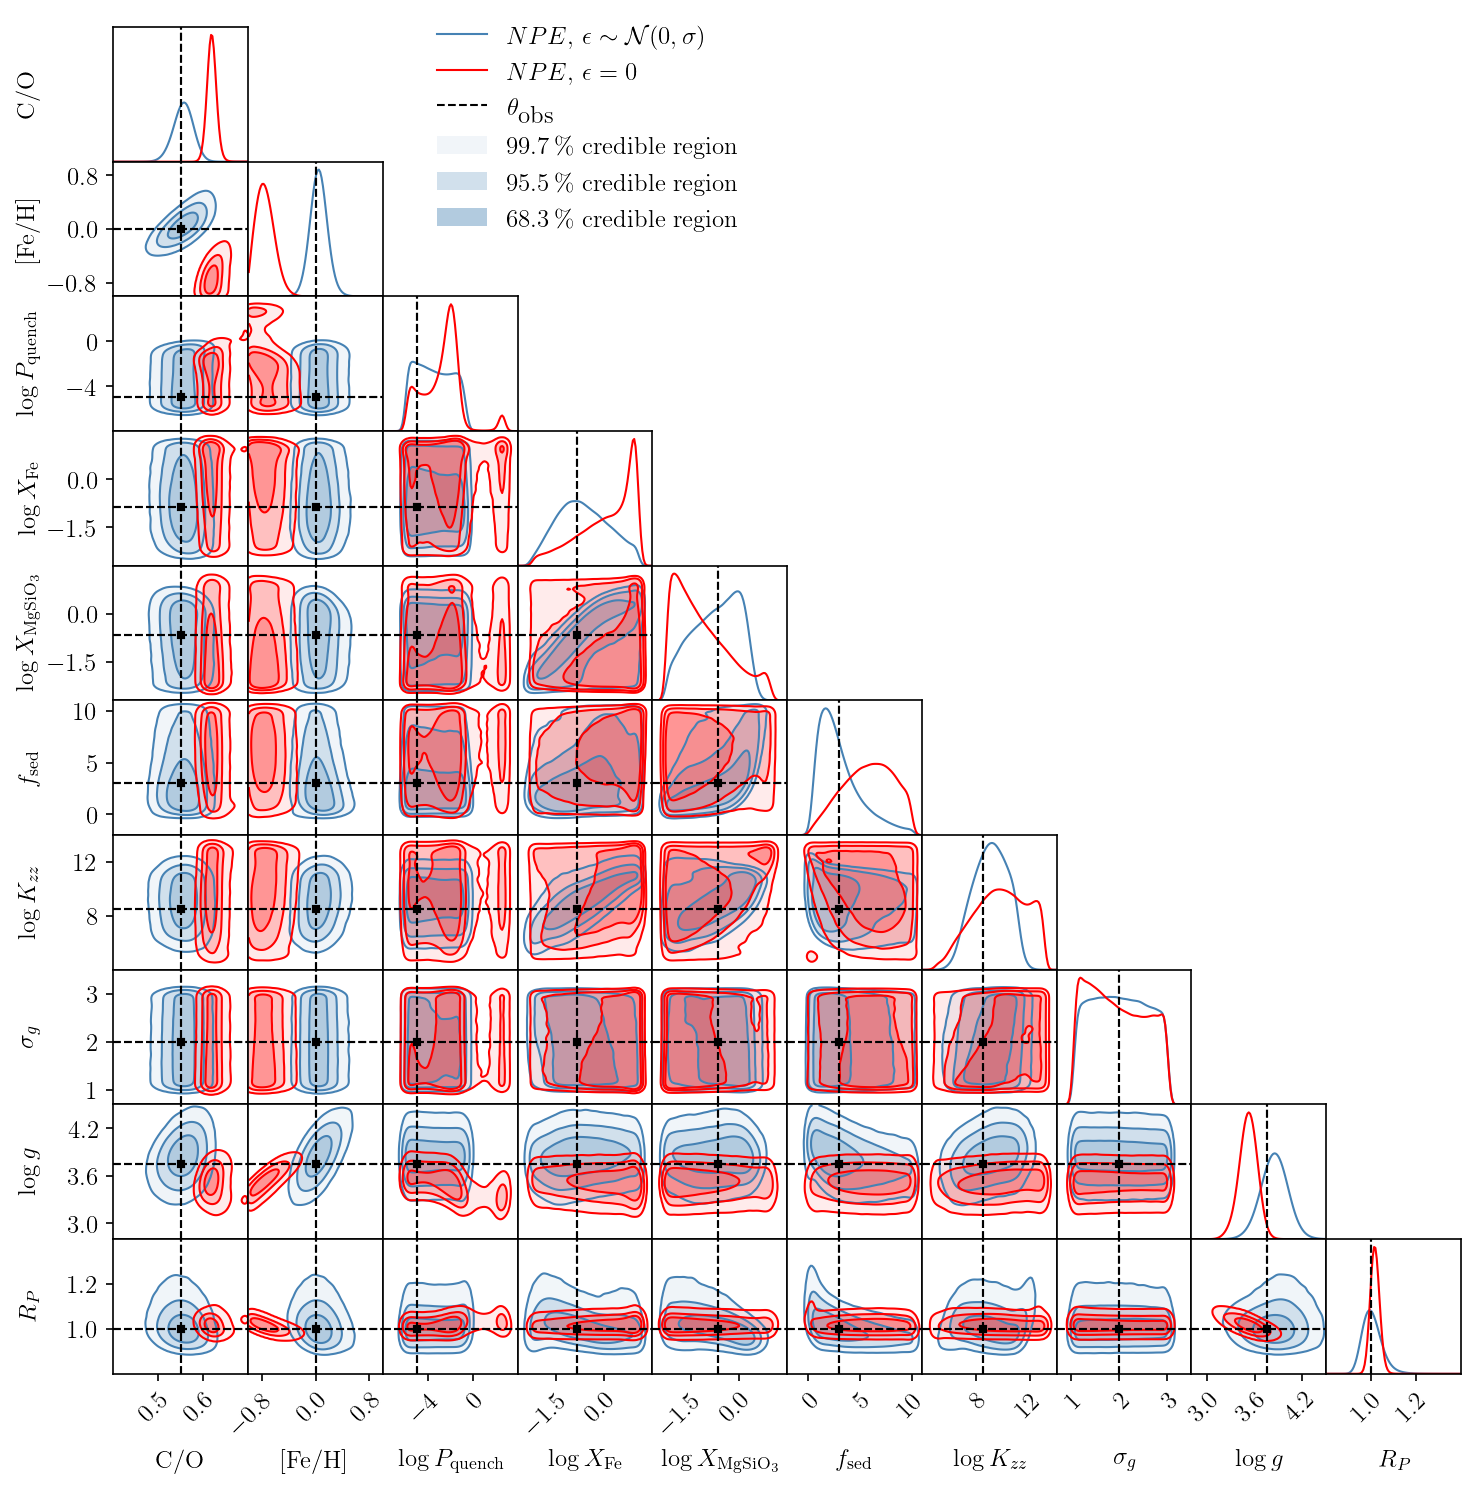

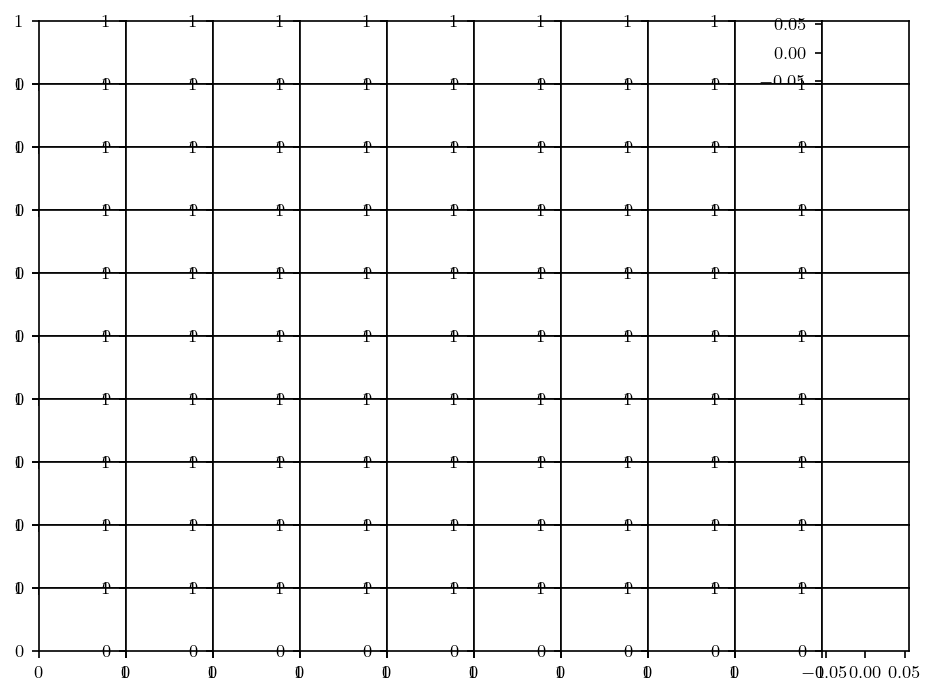

In [16]:
fig1 = corner(
        theta0[:,:10],
        smooth=2,
        bounds=(bounds_lower, bounds_upper), #LOWER,UPPER
        labels=LABELS[:10],
#         legend=r'NPE $q_{\phi}(\theta | x^*)$',
        markers=[theta_star[:10]],
        figsize=(10,10),
        color= 'steelblue')

fig =  corner(
    theta0_nl[:, :10],
    smooth=2,
    bounds = (bounds_lower, bounds_upper),
    labels=LABELS[:10],
#     legend='Nested noiseless',
    markers=[theta_star[:10]],
    color='red',
    figure= fig1

    )

figure, axes = plt.subplots( 10, 10, squeeze=False, sharex='col', gridspec_kw={'wspace': 0., 'hspace': 0.})
color = ['steelblue', 'red']
legend= [r'$NPE, \, \epsilon \sim \mathcal{N} (0,\sigma)$',r'$NPE, \, \epsilon = 0$']
for i in range(len(legend)):
    lines = axes[0, -1].plot([], [], color=color[i], label=legend[i])
dot = axes[0, -1].plot([], [], color='black', label= r"$\theta_\textnormal{obs}$", linestyle= 'dashed')
handles, texts = legends(axes = axes) 

for indx,ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=12)
    if indx<10:
        if indx==0:
            ax.set_xlabel('', fontsize=12)
            ax.set_ylabel(LABELS[indx], fontsize=12)
        else:
            ax.set_xlabel(LABELS[indx], fontsize=12)
            ax.set_ylabel(LABELS[indx], fontsize=12)
    else:continue
        
fig.legends.clear()
fig.legend(handles, texts, loc='center', bbox_to_anchor=(0.4,0.915), frameon=False,  prop={'size': 12})

fig.savefig(savepath / 'noise_by_10/corner_noiseless_nl_.pdf')


## Residuals

In [ ]:
# fig, (ax1, ax2) = plt.subplots(2, figsize=(6.4,6.4), gridspec_kw={'height_ratios': [3, 1]})

# color = np.arange(1, 3 + 1) #c = np.arange(1, 7 + 1)
# norm = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
# cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
# cmap.set_array([])

# cl=0
# for q in [0.997, 0.955, 0.683]:
# #     print(left, right)
#     lower, upper = np.quantile(x, [0.5 - q / 2, 0.5 + q / 2], axis=0)
#     ax1.fill_between([],[], label= str(round((q*100.0),1))+'$\%$', color= cmap.to_rgba(cl/2+2), alpha=0.5)
#     ax1.fill_between(wlength, lower, upper, color= cmap.to_rgba(cl/2+2), alpha=0.25, linewidth=0) #color = steelblue
#     cl+=1
    
# ax1.plot(wlength, x_star, color='black', label = r'$ X^{\ast}+\epsilon$', linewidth = 1)

# ax1.set_xticks(np.arange(0.9, 2.6, 0.2),fontsize=12) 
# ax1.set_yticks(np.arange(0, 3.8, 0.4), fontsize=12)
# ax1.set_ylabel(r'Planet flux $F_\nu$' '\n' r'(10$^{-16}$ W m$^{-2}$ $\mu$m$^{-1}$)', fontsize = 12)
# ax1.set_ylim(-0.5,3.8)
# ax1.legend(prop = {'size': 12})
# ax1.grid()
# ax1.fill_between([],[], label= r'$q_{\phi}(\theta | X^{\ast}+\epsilon)$',color = 'white')

# residuals = (torch.from_numpy(x) - x_star) / simulator.sigma

# cl=0
# for q in [0.997, 0.955, 0.683]:
#     lower, upper = np.quantile(residuals.numpy(), [0.5 - q / 2, 0.5 + q / 2], axis=0)
# #     ax2.fill_between(wlength, lower, upper, color='steelblue', alpha=0.25, linewidth=0)
#     ax2.fill_between(wlength, lower, upper, color= cmap.to_rgba(cl/2+2), alpha=0.25)
#     cl+=1
    
# ax2.set_xticks(np.arange(0.9, 2.6, 0.2),fontsize=12) 
# ax2.set_yticks(np.arange(-4,7,2), fontsize=12)
# ax2.set_ylabel(r'$q_{\phi}(\epsilon| X^{\ast}+\epsilon)$', fontsize = 12)
# ax2.set_xlabel( r'Wavelength ($\mu$m)', fontsize = 12)
# # plt.ylim(-5,5)
# # ax2.legend(prop = {'size': 12})
# ax2.grid()
# fig.savefig(savepath / 'residuals.pdf')
# plt.show()


## COLOR 

In [ ]:
# color = np.arange(1, 3 + 1) #c = np.arange(1, 7 + 1)
# norm = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
# cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
# cmap.set_array([])

# cl=0
# for q in [0.997, 0.95, 0.68]:
#     lower, upper = np.quantile(x, [0.5 - q / 2, 0.5 + q / 2], axis=0)
#     left, right = np.quantile(temperatures, [0.5 - q / 2, 0.5 + q / 2], axis=0)

#     ax.fill_between(wlength, lower, upper, color='C0', alpha=0.25, linewidth=0)
#     ax1.fill_between([],[], label= str(round((q*100.0),1))+'$\%$', color= cmap.to_rgba(cl/2+2), alpha=0.5)
#     ax1.fill_between(wlength, lower, upper, color= cmap.to_rgba(cl/2+2), alpha=0.25, linewidth=0) #color = steelblue
#     
#     ax.fill_betweenx(pressures, left, right, color= cmap.to_rgba(cl/2+2), alpha=0.25, linewidth=0) #color = steelblue
#     ax.fill_between([],[], label= str(round((q*100.0),1))+'$\%$', color= cmap.to_rgba(cl/2+2), alpha=0.5)

    #cl+=1


    ######NEW#########
#     color = np.arange(1, 5 + 1) #c = np.arange(1, 7 + 1)
#     norm = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
#     cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
#     cmap.set_array([])
#     cl=0
#     for q in [0.997, 0.955, 0.683]:
#         handles.append(mpl.patches.Patch(color = cmap.to_rgba(cl/2+2), linewidth=0))
#         texts.append(str(round((q*100.0),1))+'$\%$')
#         cl+=1
    ######NEW#########

## sp_high

In [ ]:
## sp_high samples

#(sp[0] > 0.55)| (sp[6] > 10) (sp[6] < 6) |(sp[9] < 3.6)

###One at a time  - all outside
# trial = np.array([.53, -0.09, -2.5, -1.3, -0.65, 5, 7.3, 1.5, 3.7, 0.98, 1050, 0.3, 0.08, 0.08, 1.33, 0.49])
# spec = sim(trial)
# for i in [x0_star, x_star]:
#     plot_outside(wlen, spec,i)
# plt.show()

#2) 0.524922	-0.216518	-1.130782	0.899483	0.407956	8.330844	10.099215	1.25916	3.553611	0.942615	2201.968506	0.617426	0.361865	0.783648	1.449283	0.836325


## LOSS

In [ ]:
# loss_pd = pd.read_csv('/home/mvasist/scripts_lampe/loss_atomic-sun.csv', delimiter = ',', header=[0])
# loss= torch.from_numpy(loss_pd.values)

# plt.figure(figsize=(6.4, 3.2))
# plt.plot(loss[:,1], label = r'$-log \, q_{\phi}(\theta|x)$', color = 'orange')

# trainset = H5Dataset(datapath / 'train.h5', batch_size=2**4, shuffle=False)
# t = torch.stack([theta[0] for theta, x in islice(trainset, 2**10)]).cpu().numpy()
# prior = BoxUniform(torch.tensor(LOWER), torch.tensor(UPPER))
# h = -prior.log_prob(torch.from_numpy(t)) #+13.8
# plt.axhline(h[0], label = r'$-log \, p(\theta)$', color = 'red')
# plt.ylabel('Loss', fontsize=14)
# plt.xlabel('epochs', fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(loc = (0.70,0.6), prop={'size': 12})
# plt.savefig( savepath / "loss.pdf", format="pdf", bbox_inches="tight")
# plt.show()


## Outside posterior spectra

In [ ]:
# c = ['red', 'black', 'purple', 'blue', 'red', 'grey' , 'yellow', 'orange', 'black']

# fig , ax = plt.subplots(figsize=(4,4))
# ax.plot([],[], color = 'white', alpha = 0.1, label = 'Gaussian noise')
# ax.fill_between(wlength, x0_star-simulator.sigma, x0_star+simulator.sigma, color = 'grey', alpha = 0.8)
# ax.fill_between(wlength, x0_star-2*simulator.sigma, x0_star+2*simulator.sigma, color = 'grey', alpha = 0.2)
# ax.fill_between(wlength, x0_star-3*simulator.sigma, x0_star+3*simulator.sigma, color = 'grey', alpha = 0.2)
# ax.grid()

# spec= [simulator(sp_high.values[0])]   
# for s in range(len(sp_high.values)-1):
#     simulated = simulator(sp_high.values[s+1])
#     spec = np.append(spec,[simulated], axis=0)
    
# res = ((spec-x0_star.numpy())**2).mean(axis=1)
# indx = sorted(range(len(res)), key=lambda k: res[k])
# print(indx)

# ind = [indxa, indxb, indxc]

# for j, i in enumerate(ind):  #enumerate indx  for j in np.arange(0,len(sp_high[:5])):
# #     print(i)
# #     if ind>2:break ########################
#     sp = simulator(i)  #sp_high.values[j]
#     ax.plot(wlength, sp, color=c[j], linewidth= 0.6, label = '') #color=c[j]
    
# handles, texts = legends(axes = ax, color = 'grey', alpha=[0.05,0.8], labl = True)  
        
# ax.set_xticklabels(np.round(np.arange(0.8, 2.6, 0.2),1), fontsize=8)
# ax.set_yticklabels(np.round(np.arange(0, 4.0, 0.4),1), fontsize=8)
# ax.set_xlabel('Wavelength ($\mu$)', fontsize=10)
# ax.set_ylabel(r'Planet flux $F_\nu$ (10$^{-16}$ W m$^{-2}$ $\mu$m$^{-1}$)', fontsize = 10)
# ax.legend(handles, texts, prop={'size':8})#, bbox_to_anchor=(0.55,0.98))  #(0.51,0.76)
# plt.savefig(savepath / 'outside_posterior_samples_spectra.pdf')
# plt.show()


## Old samples outside

In [ ]:
# sp = pd.DataFrame(theta)
# indx_high = sp[(sp[0] > 0.55) | (sp[1] > -0.1)| (sp[2] < -1.5)|(sp[3]< 0) | (sp[4] < 0) |(sp[5] < 5)| (sp[6] < 10) |(sp[8] > 3.6) |(sp[9] > 0.95)].index #    #everything lesser than 0
# sp_high = sp.drop(indx_high)
# sp_high.to_csv(savepath/ 'sp_high.csv')
